In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil

from joblib import Parallel, delayed

In [2]:
# !ls /home/kaor/whale/yolo/images/

In [3]:
import sys
sys.path.append("./yolov5")

In [7]:
import torch
model_backfin = torch.hub.load('ultralytics/yolov5','custom',path = 'best (1).pt',)

Using cache found in /home/kaor/.cache/torch/hub/ultralytics_yolov5_master


requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...

requirements: pandas>=1.1.4 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-12-20 torch 1.7.1+cu110 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)




requirements: 2 packages updated per /sise/home/kaor/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 444 layers, 86173414 parameters, 0 gradients
Adding AutoShape... 


In [16]:
model_backfin.conf = 0.5
df_train = pd.read_csv("train_bbox.csv")
df_train.head()

,xmin,ymin,xmax,ymax,confidence,class,name,image
0,0.960743,107.267738,774.710205,650.369751,0.488668,0,whale,00021adfb725ed.jpg
1,524.010681,575.779846,3501.782227,1424.643188,0.717447,0,whale,000562241d384d.jpg
2,0.000000,416.423676,2920.343506,1506.372559,0.770148,0,whale,0007c33415ce37.jpg
3,1499.613037,422.360046,2804.900391,1333.949951,0.210688,0,whale,0007c33415ce37.jpg
4,16.557789,60.929802,2131.614014,1428.078369,0.765196,0,whale,0007d9bca26a99.jpg


  0%|          | 4/51033 [00:00<2:16:39,  6.22it/s]

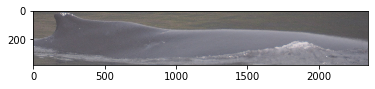

  0%|          | 6/51033 [00:01<2:52:25,  4.93it/s]

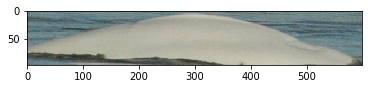

  0%|          | 8/51033 [00:01<3:12:28,  4.42it/s]

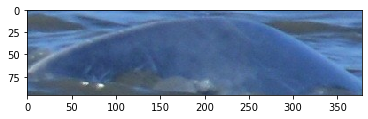

  0%|          | 11/51033 [00:02<2:44:30,  5.17it/s]

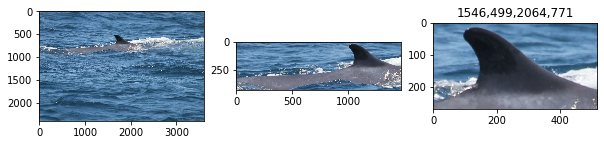

  0%|          | 12/51033 [00:03<6:26:16,  2.20it/s]

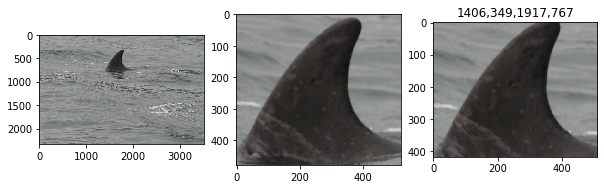

  0%|          | 13/51033 [00:04<8:54:03,  1.59it/s]

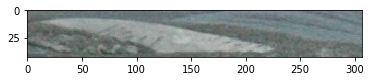

  0%|          | 14/51033 [00:04<7:02:49,  2.01it/s]

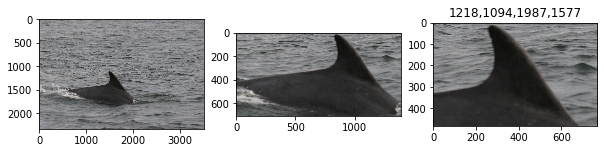

  0%|          | 15/51033 [00:05<9:28:54,  1.49it/s]

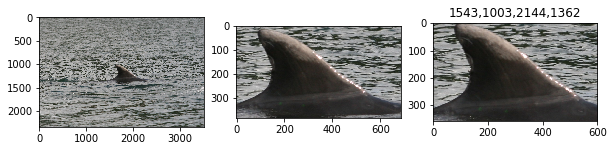

  0%|          | 16/51033 [00:06<10:56:53,  1.29it/s]

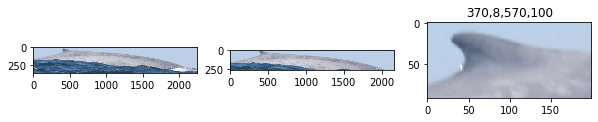

  0%|          | 17/51033 [00:07<9:41:54,  1.46it/s] 

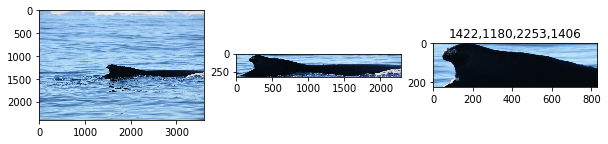

  0%|          | 18/51033 [00:08<11:55:54,  1.19it/s]

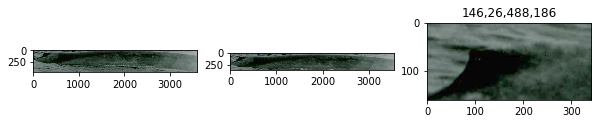

  0%|          | 19/51033 [00:08<10:51:32,  1.30it/s]

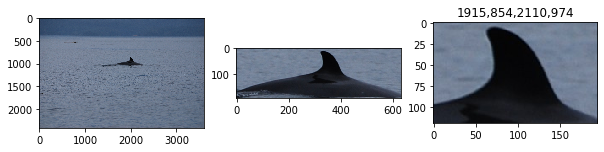

  1%|          | 552/51033 [01:05<1:40:06,  8.40it/s]


KeyboardInterrupt: 

In [19]:
%matplotlib inline
from tqdm import tqdm
r = glob.glob("/home/kaor/whale/train_images/*jpg")
df_list = []
err = []
if True:
    for i in tqdm(range(0,len(r))):
        img= cv2.imread(r[i])[:,:,::-1]
        name = r[i].split("/")[-1]
        mini = df_train[df_train.image==name]
        if len(mini) > 0:
            x0,y0,x1,y1 = mini.values[0][:4].astype(int)
            img2 = img[y0:y1,x0:x1]
        else:
            img2 = img.copy()
        res = model_backfin(img2,size=512)
        if res.xyxy[0].shape[0] != 0:
            d_f = res.pandas().xyxy[0]
            d_f['xmin'] = d_f['xmin'] + x0
            d_f['ymin'] = d_f['ymin'] + y0
            d_f['xmax'] = d_f['xmax'] + x0
            d_f['ymax'] = d_f['ymax'] + y0
            d_f['image'] = r[i].split("/")[-1]
            df_list.append(d_f)
            if i>10 and i<20:
                plt.figure(figsize=[10,5])
                plt.subplot(131)
                plt.imshow(img)
                plt.subplot(132)
                plt.imshow(img2)
                plt.subplot(133)
                x0,y0,x1,y1 = d_f.values[0,:4].astype(int)
                plt.imshow(img[y0:y1,x0:x1])
                plt.title(f"{x0},{y0},{x1},{y1}")
                plt.show()
        else:
            if i<20:
                plt.imshow(img2)
                plt.show()
            err.append(r[i])
            # print(r[i])

pd.concat(df_list).to_csv("train_bbox_backfin.csv",index=False)
np.savez_compressed("train_bbox_backfin.npz",err = np.array(err))
    #     img = cv2.imread(r[i])
    #     if res.xyxy[0].shape[0] != 0:
    #         for row in res.pandas().xyxy[0].values:
    #             x0,y0,x1,y1,c,cl,n = row
    #             img = cv2.rectangle(img,(int(x0),int(y0)),(int(x1),int(y1)),(255,0,0),int(max(img.shape[0],img.shape[1])/60))
    #             break
    #     plt.imshow(img[:,:,::-1])
    # plt.show()

In [ ]:
r = glob.glob("/home/kaor/whale/test_images/*jpg")
df_list = []
err = []
df_test = pd.read_csv("test_bbox.csv")
if True:
    for i in tqdm(range(0,len(r))):
        img= cv2.imread(r[i])[:,:,::-1]
        name = r[i].split("/")[-1]
        mini = df_test[df_test.image==name]
        if len(mini) > 0:
            x0,y0,x1,y1 = mini.values[0][:4].astype(int)
            img2 = img[y0:y1,x0:x1]
        else:
            img2 = img.copy()
        res = model_backfin(img2,size=512)
        if res.xyxy[0].shape[0] != 0:
            d_f = res.pandas().xyxy[0]
            d_f['xmin'] = d_f['xmin'] + x0
            d_f['ymin'] = d_f['ymin'] + y0
            d_f['xmax'] = d_f['xmax'] + x0
            d_f['ymax'] = d_f['ymax'] + y0
            d_f['image'] = r[i].split("/")[-1]
            df_list.append(d_f)
            if i>10 and i<20:
                plt.figure(figsize=[10,5])
                plt.subplot(131)
                plt.imshow(img)
                plt.subplot(132)
                plt.imshow(img2)
                plt.subplot(133)
                x0,y0,x1,y1 = d_f.values[0,:4].astype(int)
                plt.imshow(img[y0:y1,x0:x1])
                plt.title(f"{x0},{y0},{x1},{y1}")
                plt.show()
        else:
            if i<20:
                plt.imshow(img2)
                plt.show()
            err.append(r[i])
            # print(r[i])
            
pd.concat(df_list).to_csv("test_bbox_backfin.csv",index=False)
np.savez_compressed("test_bbox_backfin_err.npz",err = np.array(err))

  0%|          | 0/27956 [00:00<?, ?it/s]

In [ ]:
len(np.load("test_bbox_err.npz")['err']),len(np.load("train_bbox_err.npz")['err'])